# Dashboard Test A/B - SA

Extract on _sportaventure_

![](./img/eric-lsd.png )

In [1]:
!mkdir ./data

mkdir: impossible de créer le répertoire « ./data »: Le fichier existe


In [2]:
import pandas as pd
from elasticsearch import Elasticsearch
from time import gmtime, strftime
from itertools import groupby
from operator import itemgetter
import datetime

In [3]:
start = datetime.date(2017, 2, 25)
delta = datetime.date.today() - start
delta_day =delta.days
# delta_day = 13
print(delta_day)

32


In [4]:
client = Elasticsearch(hosts='172.16.0.11:9200')
body = """
{
  "query": {
    "bool": {
      "must": [
        {
          "term": {
            "site_id": {
              "value": "1626"
            }
          }
        },
        {
          "range": {
            "record_date": {
              "gte": "now-"""+str(delta_day)+"""d/d",
              "lte": "now"
            }
          }
        }
      ]
    }
  },
  "aggs": {
    "group": {
      "terms": {
        "field": "sampler_abgroup",
        "size": 10
      },
      "aggs": {
        "order_id": {
          "terms": {
            "field": "order_id",
            "size": 20000
          },
          "aggs": {
            "record_date": {
              "terms": {
                "field": "record_date",
                "size": 400
              },
              "aggs": {
                "total_price": {
                  "terms": {
                    "field": "total_w_tax",
                    "size": 100
                  },
                  "aggs": {
                    "is_canceld": {
                      "terms": {
                        "field": "is_cancelled",
                        "size": 100
                      },
                      "aggs": {
                        "visitor": {
                          "terms": {
                            "field": "visitor_id",
                            "size": 100
                          }
                        }
                      }
                    }
                    
                  }
                }
              }
            }
          }
        }
      }
    }
  }
}
"""
index = 'orders'
resp = client.search(index=index, 
                      body = body)

In [5]:
data = resp['aggregations']['group']['buckets']
extract = []
for group in data:
    #print(group['key'])
    for order in group['order_id']['buckets']:
        #print(order['key'])
        for date in order['record_date']['buckets']:
            #print(date['key_as_string'])
            for price in date['total_price']['buckets']:
                #print(price['key'])
                for is_canceled in price['is_canceld']['buckets']:
                    #print(is_canceled['key_as_string'] + '\n')
                    for visitor in is_canceled['visitor']['buckets']:
                        extract.append([group['key'],
                                   order['key'],
                                   date['key_as_string'],
                                   price['key'],
                                   is_canceled['key_as_string'],
                                   visitor['key']])
len(extract);

In [6]:
df = pd.DataFrame(extract)
col = ['group', 'order_id', 'date', 'total_price', 'is_canceled', 'visitor_id']
df.columns = col
df.sort_values(['date'])

# df = pd.read_csv('./data/Stats SA 1003 1.0.csv')
# df

group   order_id                      date  total_price is_canceled  \
527      a  100019952  2017-02-25T08:56:36.004Z       215.83       false   
0        b  100019953  2017-02-25T09:08:33.004Z        29.96       false   
528      a  100019954  2017-02-25T09:29:24.004Z        38.29        true   
1        b  100019955  2017-02-25T09:55:36.004Z       105.01       false   
529      a  100019956  2017-02-25T10:58:48.004Z       155.20       false   
2        b  100019957  2017-02-25T13:39:44.004Z       365.83        true   
530      a  100019958  2017-02-25T14:14:38.004Z       227.08       false   
531      a  100019959  2017-02-25T15:39:25.004Z        30.37       false   
3        b  100019960  2017-02-25T16:22:28.004Z        99.54        true   
4        b  100019961  2017-02-25T16:35:37.004Z       144.96       false   
5        b  100019962  2017-02-25T17:16:53.004Z        66.62       false   
6        b  100019964  2017-02-25T17:43:57.004Z       137.46       false   
532      a  100019965  2017-02-25T18:24:04.004Z       160.00        true   
7        b  100019966  2017-02-25T18:25:03.004Z       165.83        true   
533      a  100019967  2017-02-25T18:50:55.004Z       160.00       false   
534      a  100019968  2017-02-25T20:00:01.004Z        99.96        true   
8        b  100019970  2017-02-25T21:06:07.004Z       227.08       false   
535      a  100019969  2017-02-25T21:08:35.004Z        74.17       false   
536      a  100019971  2017-02-25T21:48:42.004Z        91.62        true   
537      a  100019972  2017-02-25T22:42:36.004Z        21.17       false   
538      a  100019973  2017-02-26T06:26:50.004Z       121.58       false   
539      a  100019974  2017-02-26T10:26:52.004Z       650.00        true   
9        b  100019975  2017-02-26T10:51:25.004Z       209.07        true   
540      a  100019976  2017-02-26T11:12:23.004Z       125.00       false   
10       b  100019977  2017-02-26T11:27:24.004Z       365.83       false   
541      a  100019978  2017-02-26T11:30:07.004Z        13.29       false   
542      a  100019979  2017-02-26T12:28:44.004Z        21.66        true   
543      a  100019980  2017-02-26T12:30:16.004Z        21.66       false   
544      a  100019981  2017-02-26T14:13:30.004Z       110.00       false   
545      a  100019982  2017-02-26T14:28:31.004Z        66.62       false   
...    ...        ...                       ...          ...         ...   
985      a  100020936  2017-03-26T20:31:21.004Z       393.21       false   
986      a  100020937  2017-03-26T20:39:07.004Z        64.08       false   
514      b  100020938  2017-03-26T21:00:50.004Z       207.50       false   
515      b  100020939  2017-03-27T08:30:18.004Z      1383.26        true   
516      b  100020940  2017-03-27T08:36:56.004Z      1415.83        true   
517      b  100020941  2017-03-27T08:41:50.004Z      1415.83        true   
518      b  100020942  2017-03-27T09:27:31.004Z        45.73        true   
987      a  100020943  2017-03-27T09:57:02.004Z       155.79       false   
519      b  100020944  2017-03-27T10:03:20.004Z       367.33       false   
520      b  100020945  2017-03-27T10:18:39.004Z        45.73       false   
988      a  100020946  2017-03-27T11:40:34.004Z       104.17       false   
989      a  100020947  2017-03-27T12:08:29.004Z        25.71        true   
521      b  100020948  2017-03-27T12:48:51.004Z        50.75       false   
991      a  100020950  2017-03-27T17:10:42.004Z       306.62       false   
990      a  100020949  2017-03-27T17:49:11.004Z       285.39       false   
992      a  100020951  2017-03-27T19:51:01.004Z        71.58       false   
993      a  100020952  2017-03-27T20:23:28.004Z        29.83       false   
994      a  100020953  2017-03-28T06:53:10.004Z        63.21       false   
522      b  100020954  2017-03-28T09:05:02.004Z       212.50       false   
523      b  100020956  2017-03-28T09:29:38.491Z        99.00       false   
995      a  100020958  2017-03-28T09:39:50.004Z      

In [7]:
df.to_csv('./data/extract_testAB_SA_{0}.csv'.format(strftime("%Y-%m-%d_%H:%M:%S", gmtime())))

In [8]:
df = df[df.visitor_id != '00000000-0000-0000-0000-000000000000']
df = df[df.visitor_id != '1e19d200-3cdd-4786-87f3-abb472978615']

In [9]:
# df_no_canceled = df[df.is_canceled == 'false']
df_no_canceled = df

# df_no_canceled = df[df.StatutMagento != 'Canceled']

### Nombre de commande (sans canceled orders)

In [10]:
print("Nombre de commande total: {}".format(len(df_no_canceled)))
print("Total price A: {}".format(df_no_canceled[df_no_canceled.group == 'a'].total_price.sum()))
pd.value_counts(df_no_canceled.group)
print("Total price B: {}".format(df_no_canceled[df_no_canceled.group == 'b'].total_price.sum()))
pd.value_counts(df_no_canceled.group)

# print("Nombre de commande total: {}".format(len(df_no_canceled.Newgroup)))
# print("Total price A: {}".format(df_no_canceled[df_no_canceled.Newgroup == 'a'].total_price.sum()))
# pd.value_counts(df_no_canceled.Newgroup)
# print("Total price B: {}".format(df_no_canceled[df_no_canceled.Newgroup == 'b'].total_price.sum()))
# pd.value_counts(df_no_canceled.Newgroup)

Nombre de commande total: 971
Total price A: 76908.18000000007
Total price B: 86976.07


b    494
a    477
Name: group, dtype: int64

In [11]:
sales_groups = pd.value_counts(df_no_canceled.group)
sales_A = sales_groups['a']
sales_B = sales_groups['b']

### Nombre de commande (avec canceled orders)

In [12]:
print("Nombre de commande total: {}".format(len(df)))
print("Total price A: {}".format(df[df.group == 'a'].total_price.sum()))
print("Total price B: {}".format(df[df.group == 'b'].total_price.sum()))
pd.value_counts(df.group)

Nombre de commande total: 971
Total price A: 76908.18000000007
Total price B: 86976.07


b    494
a    477
Name: group, dtype: int64

In [13]:
def missed_order(order):
    missed_order = []
    max_id = max(order)
    min_id = min(order)
    for order_id in range(min_id, max_id):
        if order_id not in order:
            missed_order.append(order_id)
    return missed_order    
        

In [14]:
df.order_id = df.order_id.map(lambda x: int(x))
missing_orders = missed_order(df.order_id.values)


### Commandes manquantes

In [15]:
print('Nombre de commandes manquantes : {}'.format(len(missing_orders)))

Nombre de commandes manquantes : 127


In [16]:
print(missing_orders)

[100019880, 100019881, 100019882, 100019883, 100019884, 100019885, 100019886, 100019887, 100019888, 100019889, 100019890, 100019891, 100019892, 100019893, 100019894, 100019895, 100019896, 100019897, 100019898, 100019899, 100019900, 100019901, 100019902, 100019903, 100019904, 100019905, 100019906, 100019907, 100019908, 100019909, 100019910, 100019911, 100019912, 100019913, 100019914, 100019915, 100019916, 100019917, 100019918, 100019919, 100019920, 100019921, 100019922, 100019923, 100019924, 100019925, 100019926, 100019927, 100019928, 100019929, 100019930, 100019931, 100019932, 100019933, 100019934, 100019935, 100019936, 100019937, 100019938, 100019939, 100019940, 100019941, 100019942, 100019943, 100019944, 100019945, 100019946, 100019947, 100019948, 100019949, 100019950, 100019951, 100019963, 100019964, 100020001, 100020005, 100020015, 100020019, 100020023, 100020024, 100020060, 100020127, 100020132, 100020136, 100020290, 100020308, 100020328, 100020342, 100020379, 100020397, 100020398

# Test A/B bayésien

In [17]:
import scipy.stats as st
import numpy as np

In [18]:
client = Elasticsearch(hosts='172.16.0.11:9200')

body = """{
  "query": {
    "bool": {
      "must": [
        {
          "match": {
            "site_id": "1626"
          }
        },
        {
          "range": {
            "created": {
              "gte": "now-"""+str(delta_day)+"""d/d",
              "lt": "now"
            }
          }
        },
        {
          "match": {
            "event_name": "page_visit"
          }
        },
        {
          "match": {
            "session_pages": 1
          }
        }
      ]
    }
  },
  "aggs": {
    "groupe": {
      "terms": {
        "field": "sampler_abgroup",
        "size": 10
      }
    }
  }
} """


index = 'events'
resp_sess = client.search(index=index, 
                      body = body)

In [19]:
data_pars = []
visitor_A = resp_sess['aggregations']['groupe']['buckets'][0]['doc_count'] if resp_sess['aggregations']['groupe']['buckets'][0]['key'] == 'a' else resp_sess['aggregations']['groupe']['buckets'][1]['doc_count']
visitor_B = resp_sess['aggregations']['groupe']['buckets'][0]['doc_count'] if resp_sess['aggregations']['groupe']['buckets'][0]['key'] == 'b' else resp_sess['aggregations']['groupe']['buckets'][1]['doc_count']


### Nombre de visite par groupe

In [20]:
repartition_A = round(visitor_A/(visitor_A+visitor_B)*100, 2)
print("Group A : {0} visitor \t {1} sales \t Repartition: {2}%".format(visitor_A, sales_A, repartition_A))
print("Group B : {0} visitor \t {1} sales \t Repartition: {2}%".format(visitor_B, sales_B, 100-repartition_A))

Group A : 53182 visitor 	 477 sales 	 Repartition: 50.08%
Group B : 53004 visitor 	 494 sales 	 Repartition: 49.92%


In [21]:
alpha_prior = 1
beta_prior = 1

posterior_A = st.beta(alpha_prior + sales_A,
                     beta_prior + visitor_A - sales_A)
posterior_B = st.beta(alpha_prior + sales_B,
                     beta_prior + visitor_B - sales_B)

sample = 20000
sample_posterior_A = posterior_A.rvs(sample)
sample_posterior_B = posterior_B.rvs(sample)

from matplotlib import pyplot as plt
#plt.xkcd()

<IPython.core.display.Javascript object>


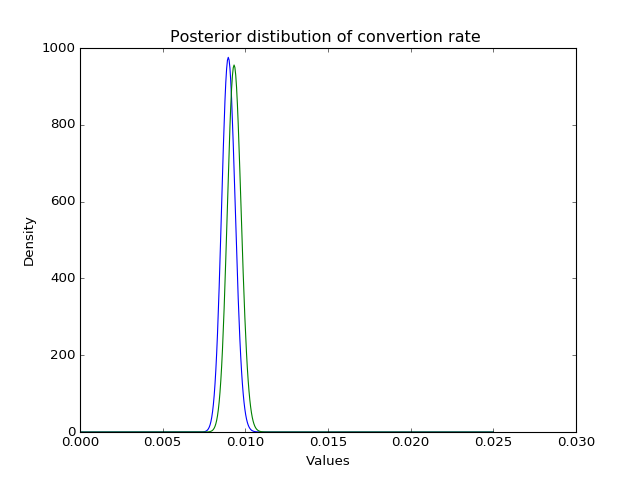

In [22]:
%matplotlib notebook

x =  np.linspace(0,0.025, 500)
plt.plot(x, posterior_A.pdf(x), label='Posterior of A')
plt.plot(x, posterior_B.pdf(x), label='Posterior of B')
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Posterior distibution of convertion rate ');

## Interpretation

In [23]:
def relative_increase(a,b):
    return (a-b)/b

posterior_rel_increase = relative_increase(sample_posterior_A, sample_posterior_B)
over_0  = (posterior_rel_increase > 0).mean() 
over_05 = (posterior_rel_increase > 0.05).mean()
over_10 = (posterior_rel_increase > 0.1).mean()
over_20 = (posterior_rel_increase > 0.2).mean()


In [24]:
A_over_B = (sample_posterior_A > sample_posterior_B).mean()
print("Group A has {0}% chance to overperform group B".format(A_over_B*100))
print("Group B has {0}% chance to overperform group A".format((1-A_over_B)*100))

Group A has 27.62% chance to overperform group B
Group B has 72.38% chance to overperform group A


In [25]:
print('Chances that relative increase is over 0 : {0}%'.format(over_0*100))
print('Chances that relative increase is over 0.05 : {0}%'.format(over_05*100))
print('Chances that relative increase is over 0.1 : {0}%'.format(over_10*100))
print('Chances that relative increase is over 0.2 : {0}%'.format(over_20*100))

Chances that relative increase is over 0 : 27.62%
Chances that relative increase is over 0.05 : 8.75%
Chances that relative increase is over 0.1 : 1.975%
Chances that relative increase is over 0.2 : 0.04%
